### Задание

Вариант 1)
1. Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" .
​
2. Оцените ошибку модели из п.1 .
3. Сделайте вывод о том, как изменилась ошибка модели по значениям h.
​
4. Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):
​<br>
а) Изменение температуры за окном :).<br>
​<br>
б) Количество денег, которые тратят покупатели в интернет магазине.<br>
​<br>
в) Вес растущего котенка.<br>
​<br>
г) Прирост объема деревьев в лесу от времени<br>

### Задачи 1-3

Импортируем необходимые библиотеки

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error

import os
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

Импортируем csv-файл

In [11]:
cons = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])

cons.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


Сформируем новый датасет, состоящий из главных значений

In [12]:
cons_arg = cons['PJME_MW'].values
cons_s = pd.DataFrame(data = cons['PJME_MW'])

Произведем ресемплинг в дневной график

In [23]:
d_cons=cons.resample('D').mean()

Оценим полученные данные

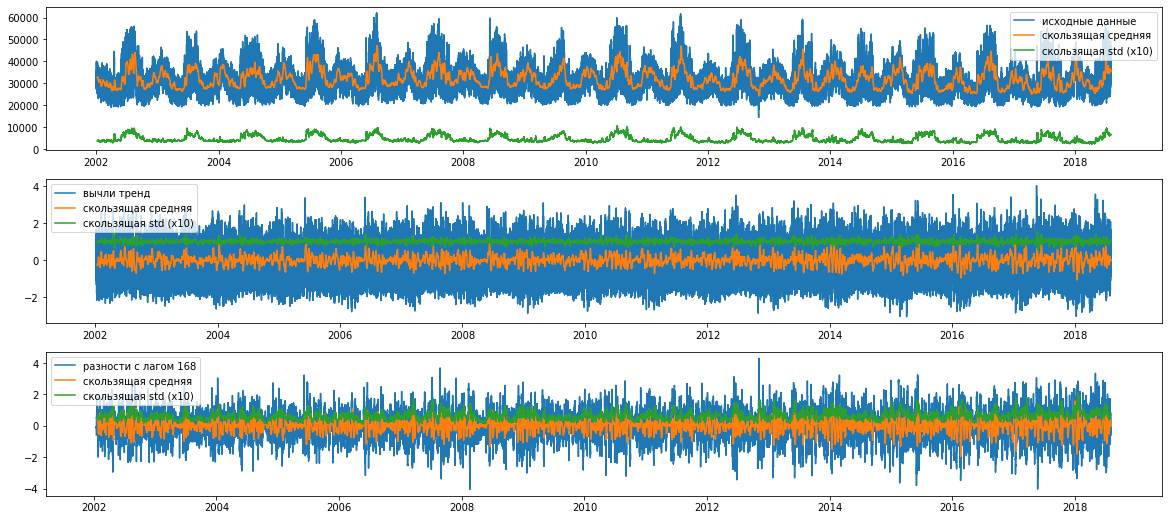

In [16]:
train = cons_s.iloc[:-10, :]
test = cons_s.iloc[-10:, :]


N2 = 24*7

cons_s['z_data'] = (cons_s['PJME_MW'] - cons_s['PJME_MW'].rolling(window=N2).mean()) / cons_s['PJME_MW'].rolling(window=N2).std()
cons_s['zp_data'] = cons_s['z_data'] - cons_s['z_data'].shift(N2)

def plot_rolling(b_s):
    fig, ax = plt.subplots(3,figsize=(20, 9))
    ax[0].plot(b_s.index, b_s['PJME_MW'], label='исходные данные')
    ax[0].plot(b_s['PJME_MW'].rolling(window=N2).mean(), label="скользящая средняя");
    ax[0].plot(b_s['PJME_MW'].rolling(window=N2).std(), label="скользящая std (x10)");
    ax[0].legend()

    ax[1].plot(b_s.index,b_s.z_data, label="вычли тренд")
    ax[1].plot(b_s.z_data.rolling(window=N2).mean(), label="скользящая средняя");
    ax[1].plot(b_s.z_data.rolling(window=N2).std(), label="скользящая std (x10)");
    ax[1].legend()

    ax[2].plot(b_s.index, b_s.zp_data, label="разности с лагом" +' '+str(N2))
    ax[2].plot(b_s.zp_data.rolling(window=N2).mean(), label="скользящая средняя");
    ax[2].plot(b_s.zp_data.rolling(window=N2).std(), label="скользящая std (x10)");
    ax[2].legend()

    #plt.tight_layout()
   #
    plt.show()
plot_rolling(cons_s)    

Применим экпоненциальное сглаживание

Text(0.5, 1.0, 'PJME_MW')

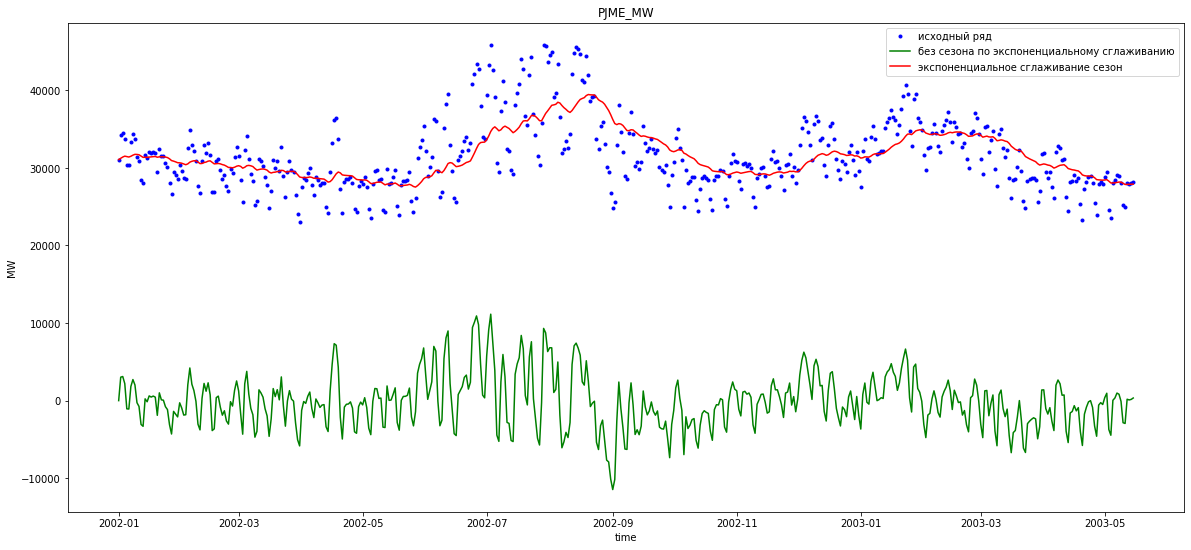

In [24]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

cons_exp_1 = exponential_smoothing(d_cons['PJME_MW']  , 0.05)
plt.figure(figsize=(20, 9))
plt.plot(d_cons.index[:500], d_cons['PJME_MW'].values[:500], '.b',label='исходный ряд')

plt.plot(d_cons.index[:500],d_cons['PJME_MW'].values[:500] - cons_exp_1[:500] , color = 'green', label="без сезона по экспоненциальному сглаживанию");

plt.plot(d_cons.index[:500],cons_exp_1[:500] , color = 'red', label="экспоненциальное сглаживание сезон");

plt.xlabel('time')
plt.ylabel('MW')
plt.legend()
plt.title('PJME_MW')

Произведем тест Дики-Фуллера

In [27]:
data_season_free = pd.DataFrame(data = (np.array(d_cons['PJME_MW']).reshape((d_cons['PJME_MW'].shape[0],1)) -cons_exp_1))
DF_ = sm.tsa.stattools.adfuller( data_season_free.iloc[:,0] , regression = 'ctt')
DF_

(-8.365362138570433,
 4.2829746151905985e-11,
 34,
 6024,
 {'1%': -4.373054660566805,
  '5%': -3.833370706612336,
  '10%': -3.55386764946938},
 107622.59914749119)

Результат оказался равен 0. Продолжим расчет

Добавим авторегрессию с глубиной 3

In [56]:
df_exp_1 =  pd.DataFrame(cons_exp_1, index = d_cons.index)
df_exp_1.head()
df_exp_1['t'] = 0
df_exp_1.iloc[1:,1]=df_exp_1.iloc[:-1,0].values
df_exp_1['t1']=0
df_exp_1.iloc[2:,2]=df_exp_1.iloc[:-2,0].values
df_exp_1['t2']=0
df_exp_1.iloc[3:,3]=df_exp_1.iloc[:-3,0].values
df_exp_1.fillna(0)

df_exp.tail()

,0,t,t1,t2
Date,,,,
2018-07-30,35241.910443,35362.146957,35530.527499,35584.989473
2018-07-31,35206.769087,35241.910443,35362.146957,35530.527499
2018-08-01,35407.970216,35206.769087,35241.910443,35362.146957
2018-08-02,35617.223789,35407.970216,35206.769087,35241.910443
2018-08-03,35610.662599,35617.223789,35407.970216,35206.769087


Разделим данные на тренировочные и тестовые по 1 ноября 2018 года

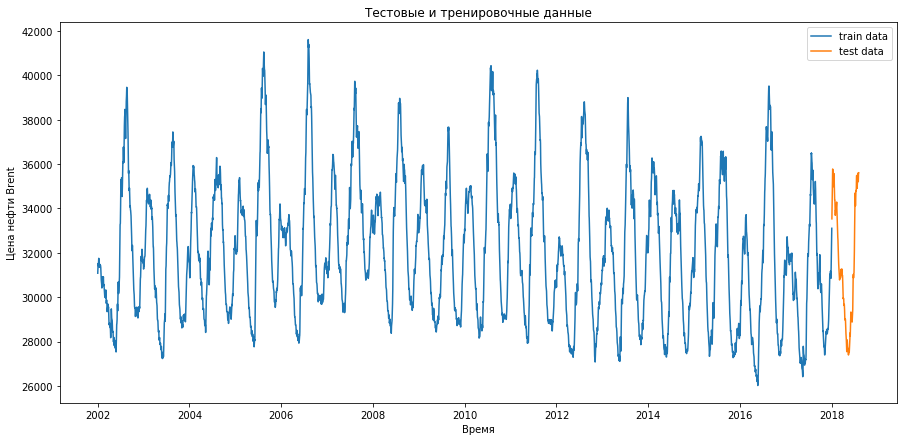

In [57]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
scl =StandardScaler()
scly =StandardScaler()

# сделаем примеры и модель 
def split_data_b( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

train_b, test_b = split_data_b( df_exp, '01-01-2018')

X_train_b = train_b.iloc[:-1,:]
y_train_b = train_b[df_exp_1.columns[0]].values[1:]
X_test_b = test_b.iloc[:-1,:]
y_test_b = test_b[df_exp.columns[0]].values[1:]


plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Цена нефти Brent')
plt.plot(train_b.index.get_level_values('Date'),train_b[df_exp.columns[0]], label='train data' )
plt.plot(test_b.index.get_level_values('Date'),test_b[df_exp.columns[0]], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

Произведем прогноз временного ряда при глубине h=1

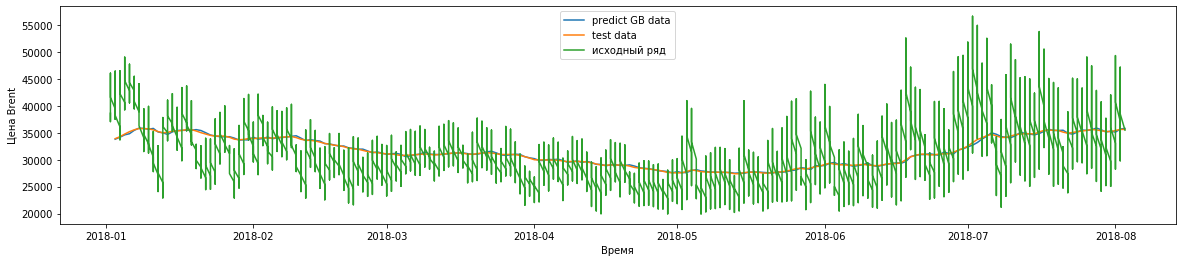

ошибка градиентного бустинга :   0.40465166744428915 %


In [58]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('Цена Brent')
plt.plot(test_b.index[1:],X_test_pred_gb, label='predict GB data' )
plt.plot(test_b.index[1:],y_test_b, label='test data')
plt.plot(cons_s.loc['2018-01-02':].index, cons_s.loc['2018-01-02':]['PJME_MW'], label='исходный ряд')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')

Повторим прогноз для глубины проноза h=10

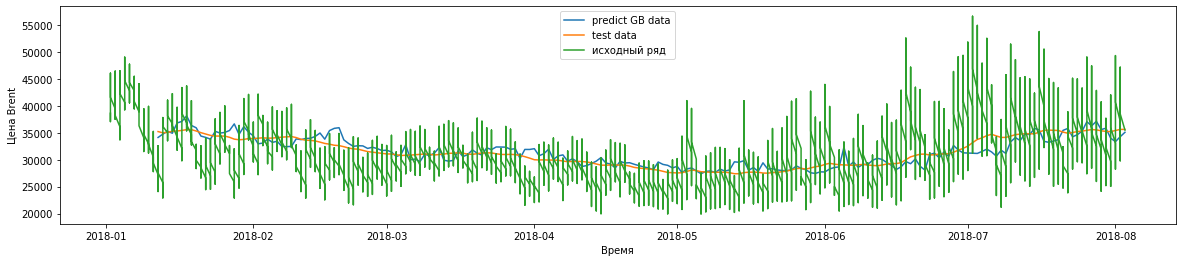

ошибка градиентного бустинга :   2.975091210822581 %


In [59]:
h=10
X_train_b = train_b.iloc[:-h,:]
y_train_b = train_b[df_exp.columns[0]].values[h:]
X_test_b = test_b.iloc[:-h,:]
y_test_b = test_b[df_exp.columns[0]].values[h:]

model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('Цена Brent')
plt.plot(test_b.index[h:],X_test_pred_gb, label='predict GB data' )
plt.plot(test_b.index[h:],y_test_b, label='test data')
plt.plot(cons_s.loc['2018-01-02':].index, cons_s.loc['2018-01-02':]['PJME_MW'], label='исходный ряд')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')

<b>Вывод</b>: при увеличении горизонта прогноза ошибка модели увеличивается. Это связано с тем, что в расчете модели может попасть шум, выбросы и прочие аномалии, которые не были зафиксированы на более коротком периоде

### Задача 4

Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):<br>
<br>
а) Изменение температуры за окном :).<br>
<b>Ответ</b>: временной ряд с сезоном т.к. данный значения зависят от календарного периода<br>
<br>
б) Количество денег, которые тратят покупатели в интернет магазине.<br>
<b>Ответ</b>: временной ряд с сезоном т.к. данный значения зависят от календарного периода (например, на Новый Год, майские праздники, покупатели тратят больше, чем в обычные дни<br>
<br>
в) Вес растущего котенка.<br>
<b>Ответ</b>: ряд с трендом т.к. вес котенка будет расти<br>
<br>
г) Прирост объема деревьев в лесу от времени<br>
<b>Ответ</b>: данный тип ряда невозможно определить т.к. значение прироста может колебаться случайно<br>